{'Host-name': ['AM2'], 'Guest': ['H3K4', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9me3', 'H3R2me2a', 'H3R2me2s']}
[ 4.42218420e-08 -4.60444653e+02] [1.78019923e-09 1.80665919e+00] 2.171251171771829
[ 3.09195727e-08 -5.15637068e+02] [1.15807326e-09 1.53905880e+00] 1.980846955789874
3.757070732213692e-08 

Using method B
H3K4 
 [1.63593888e-06 5.76465591e+02] [9.58099901e-07 1.28076591e+02] 31.779035016510512 
 [2.08451370e-06 5.93109756e+02] [1.95815544e-07 2.30998836e+01] 4.657575975017493 

Using method B
H3K4ac 
 [1.35092865e-05 1.02679059e+03] [2.26882009e-06 1.23491580e+02] 2.9622312462691416 
 [2.07240397e-06 3.78537243e+02] [6.64212736e-07 5.02451178e+01] 10.11039701410673 

Using method B
H3K4me1 
 [5.35385257e-07 6.09192127e+02] [4.43359391e-08 1.24443779e+01] 6.913920001820381 
 [5.29109926e-07 6.24149486e+02] [2.41923980e-08 7.05960224e+00] 3.8434046413323695 

Using method B
H3K4me2 
 [1.27050587e-07 6.24798503e+02] [6.97130104e-09 5.66162434e+00] 5.941936201001054 
 [

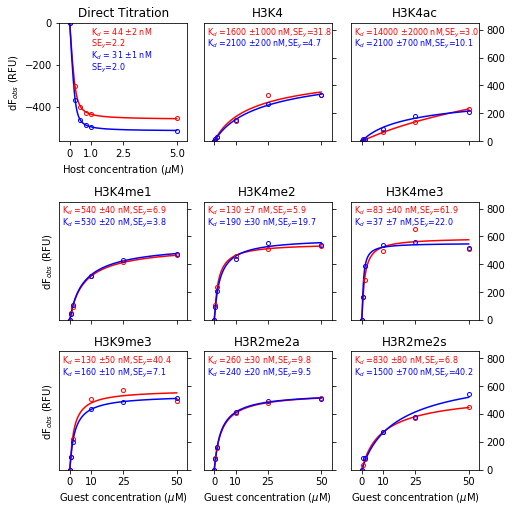

In [29]:
import import_ipynb #needed to import IDA and JL96
import IDA #contains IDA fit plus error functions(direct and competitve) and a function to calculated R-square
import JL96 #contains just one function that reads the format and returns all variable is seperate dictionaries (blank substracted)
import UnitsAndSigFigs as USF #contains functions for rounding up to significant digits

from scipy import *
from scipy.optimize import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# name is a dictionary that contains all names (host + guest)
# constant is a dictinary that conatins all concentrations that are kept constant
# direct is a dictionary with direct titration data
# competitive is a DICTIONARY OF DICTIOANRY with competitive titration data 

fname = 'data IDA.txt'
name, constant, direct, competition = JL96.readdata(fname)

print(name)
hostname=name['Host-name'][0]
#print(constant)
#print(competition)

#-----------------------------------------------------------
# The dictonaries contain data as a list. In order for numpy programs to work, these need to be 
# converted to nparray

H=np.asarray(direct['Host-direct']) # concentration points for direct titration
d1=np.asarray(direct['data 0']) # data for direct titration
d2=np.asarray(direct['data 1']) # duplicate data for direct titration

# Define method:
# A) Use [(KI/1000.0, KI*1000.), (e-100, e+100)] as k_guess for curvefit.
# B) Use brute to get k_guess,finish with fmin. Get error using curvefit.
# C) Use brute to get k_guess for curvefit
method ='B'

# Fit the data
df=min(min(d1),min(d2))
param=[(1.0e-09, 1000.0e-09),(df-100,df+100)]
k_ind_1 = brute(IDA.err_direct, param, args=(H, d1, [constant['Indicator-direct']]), finish=fmin)
k_ind_2 = brute(IDA.err_direct, param, args=(H, d2, [constant['Indicator-direct']]), finish=fmin)

# create a temp array for curve_fit that conatains indicator concentration. 1.0's are added to avoid 
# numpy's check_finite
cons_dir = [constant['Indicator-direct'],1.0,1.0,1.0,1.0,1.0]

# fit the direct titration using brute's output as initial guess. calculate the error in 
# regression (direct_err) using the covariance matrix from the output of curve_fit.
ki1=curve_fit(IDA.fit_dir_wrap, (H, cons_dir), d1, k_ind_1, check_finite=False)
direct_err1 = np.sqrt(np.diag(ki1[1]))
ki2=curve_fit(IDA.fit_dir_wrap, (H, cons_dir), d2, k_ind_2, check_finite=False)
direct_err2 = np.sqrt(np.diag(ki2[1]))

# calculate the standard error of the y-estimate
err_direct1=IDA.err_direct(ki1[0], H, d1, cons_dir)
nk=len(d1)-len(ki1[0])
s_err_direct1 = np.sqrt(err_direct1/nk)

err_direct2=IDA.err_direct(ki2[0], H, d2, cons_dir)
nk=len(d2)-len(ki2[0])
s_err_direct2 = np.sqrt(err_direct2/nk)

KI=(ki1[0][0]+ki2[0][0])/2.0 #used as a parameter for competitive titration data curve fitting

print(ki1[0], direct_err1, s_err_direct1)
print(ki2[0], direct_err2, s_err_direct2)
print(KI, '\n')

# A figure of 3X3 which has 1 direct titration + 8 competitve titration data
fig1, axs = plt.subplots(figsize=(7,7), ncols=3, nrows=3, constrained_layout=True)

# calculate the best fit curves
x=linspace(min(H), max(H), 1000)
dir_y1=IDA.fit_direct(x, ki1[0][0], ki1[0][1], constant['Indicator-direct'])
dir_y2=IDA.fit_direct(x, ki2[0][0], ki2[0][1], constant['Indicator-direct'])

# plot
axs[0,0].plot(x, dir_y1, 'r-', x, dir_y2, 'b-', H, d1, 'ro', H, d2, 'bo', markerfacecolor='none',markersize=4.0)

# decorate
axs[0,0].set_title("Direct Titration")
# decorate x
axs[0,0].set_xbound(-0.1*max(H),1.1*max(H))
axs[0,0].set_xlabel('Host concentration ('+u'${\mu}$'+'M)')
axs[0,0].set_xticks([0,1.0e-6,2.5e-6,5.0e-6])
axs[0,0].set_xticklabels([0,1.0,2.5,5.0])
# decorate y
yax=min(min(d1),min(d2))-50
axs[0,0].set_ybound(0.0, yax)
axs[0,0].set_ylabel("dF"+r'$_{obs}$'+" (RFU)")

# text for the plot ... includes Ki +/- errors and Standard error of y-estimate
#red_k="{:0=3.2f} ".format(ki1[0][0]/1e-9)+u"\u00B1"+"{:0=3.2f} ".format(direct_err1[0]/1e-9)+'nM '
red_k=USF.round_to_sig_fig(ki1[0][0], unit=1e-9, 
                           sigfig=2)+'\u00B1'+USF.round_to_sig_fig(direct_err1[0], unit='nano', 
                                                                   sigfig=1, suffix='M')
red_sey='SE'+r'$_y$='+"{:0=3.1f} ".format(s_err_direct1)
blue_k=USF.round_to_sig_fig(ki2[0][0], unit=1e-9, 
                            sigfig=2)+'\u00B1'+USF.round_to_sig_fig(direct_err2[0], unit='nano', 
                                                                    sigfig=1, suffix='M')
blue_sey='SE'+r'$_y$='+"{:0=3.1f} ".format(s_err_direct2)


# Write the text. Also give the coordinates for texts here.
ten_percent=0.1*yax
axs[0,0].text(1.0e-6, ten_percent, 'K'+r'$_d$ = '+red_k, fontsize=8, color='r')
axs[0,0].text(1.0e-6, 2*ten_percent, red_sey, fontsize=8, color='r')
axs[0,0].text(1.0e-6, 3*ten_percent, 'K'+r'$_d$ = '+blue_k, fontsize=8, color='b')
axs[0,0].text(1.0e-6, 4*ten_percent, blue_sey, fontsize=8, color='b')

for i in range(len(name['Guest'])):
    # Get the name of guest and the data from individual dictioanries
    n=name['Guest'][i] # name of peptide
    c=np.asarray(competition[n]['concentration']) # x-data
    f1=np.asarray(competition[n]['data 0']) # y-data
    f1.astype(np.float)
    f2=np.asarray(competition[n]['data 1']) # y-data duplicate
    f2.astype(np.float)
    tit=n # title if needed
    yax=850 # the y-axis. this will be constant for every subplots
    
    # const is an array that will be passed along with x-data (or c) as a tuple. 
    # Three 1.0 are added to excape numpy's check_finite 
    cons_comp = [KI, constant['Indicator-comp'], constant['Host-comp'], 1.0,1.0,1.0]
    
    # Three different methods
    # A) Use [(KI, max(y_data)] as k_guess for curvefit.
    # B) Use brute to get k_guess,finish with fmin. Polish and get error using curvefit.
    # C) Use brute to get k_guess for curvefit 
    if method == 'A':
        print('Using method A')
        # using KI and Ymax as initial guess directly for curve_fit
        k_guess_1=[KI, max(f1)]
        k_guess_2=[KI, max(f2)]
    
    elif method == 'C':
        print('Using method C')
        # using brute to generate initial guess
        e=max(max(f1), max(f2))
        params = [(KI/1000.0, KI*1000.), (e-100, e+100)]
        k_guess_1= brute(IDA.err_comp, params, args=(c, f1, [KI, constant['Indicator-comp'], constant['Host-comp']]), 
                         Ns=150, finish=None)
        k_guess_2= brute(IDA.err_comp, params, args=(c, f2, [KI, constant['Indicator-comp'], constant['Host-comp']]), 
                         Ns=150, finish=None)
        #print(n, k_guess_1, k_guess_2)
        
        # fit each competitive titration
        kg1=curve_fit(IDA.fit_comp_wrap, (c,cons_comp), f1, k_guess_1, check_finite=True)
        kg2=curve_fit(IDA.fit_comp_wrap, (c,cons_comp), f2, k_guess_2, check_finite=False)
    
    elif method == 'B':
        print('Using method B')
        # using brute to generate initial guess and finish with fmin
        e=max(max(f1), max(f2))
        params = [(KI/1000.0, KI*1000.), (e-100, e+100)]
        k_guess_1= brute(IDA.err_comp, params, args=(c, f1, [KI, constant['Indicator-comp'], constant['Host-comp']]), 
                         Ns=150, finish=fmin)
        k_guess_2= brute(IDA.err_comp, params, args=(c, f2, [KI, constant['Indicator-comp'], constant['Host-comp']]), 
                         Ns=150, finish=fmin)
        #print(n, k_guess_1, k_guess_2)
        
    # fit each competitive titration
    # IN CASE OF METHOD B, this is a mock fit, just to get covarience matrix. 
    # This also ensures that curvefit doesnot overflow to complex numbers.
    kg1=curve_fit(IDA.fit_comp_wrap, (c,cons_comp), f1, k_guess_1, check_finite=True)
    kg2=curve_fit(IDA.fit_comp_wrap, (c,cons_comp), f2, k_guess_2, check_finite=False)

    # Calculate error on each parameter fit using covariance matrix from curve_fit. 
    # This is one standard deviation error.
    kg_err1 = np.sqrt(np.diag(kg1[1]))
    kg_err2 = np.sqrt(np.diag(kg2[1]))
    
    # calculate the standard error of the y-estimate
    comp_err1=IDA.err_comp(kg1[0], c, f1, cons_comp)
    nk=len(f1)-len(kg1[0])
    s_err_comp1 = np.sqrt(comp_err1/nk)
    
    comp_err2=IDA.err_comp(kg2[0], c, f2, cons_comp)
    nk=len(f2)-len(kg2[0])
    s_err_comp2 = np.sqrt(comp_err2/nk)
      
    print(n, '\n', kg1[0], kg_err1, s_err_comp1, '\n', kg2[0], kg_err2, s_err_comp2, '\n')
    
    # text for the plot ... includes Kd +/- errors and Standard error of y-estimate
    if kg1[0][0]>100e-6:
        red_k='>100 '+'\u03BC'+'M'
    else:
        red_k=USF.round_to_sig_fig(kg1[0][0], unit=1e-9, 
                           sigfig=2, scientific_notation=False)+'\u00B1'+USF.round_to_sig_fig(kg_err1[0], unit='nano', 
                                                                   sigfig=1, suffix='M', scientific_notation=False)
    red_sey='SE'+r'$_y$='+"{:0=3.1f} ".format(s_err_comp1)
    
    if kg2[0][0]>100e-6:
        blue_k='>100 '+'\u03BC'+'M'
    else:
        blue_k=USF.round_to_sig_fig(kg2[0][0], unit=1e-9, 
                           sigfig=2, scientific_notation=False)+'\u00B1'+USF.round_to_sig_fig(kg_err2[0], unit='nano', 
                                                                   sigfig=1, suffix='M', scientific_notation=False)
    blue_sey='SE'+r'$_y$='+"{:0=3.1f} ".format(s_err_comp2)

    # these indices are used to iterate over the subplots
    j=int((i+1)/3)
    k=(i+1)%3
    
    # calculate the best fit curves
    x=linspace(min(c), max(c), 1000)
    comp_y1=IDA.fit_comp(x, kg1[0][0], kg1[0][1], KI, constant['Indicator-comp'], constant['Host-comp'])
    comp_y2=IDA.fit_comp(x, kg2[0][0], kg2[0][1], KI, constant['Indicator-comp'], constant['Host-comp'])
    
    # plot
    axs[j,k].plot(x, comp_y1, 'r-', x, comp_y2, 'b-', c, f1, 'ro', c, f2, 'bo',  markerfacecolor='none', markersize=4.0)
    
    # decorate title
    axs[j,k].set_title(tit)
    # decorate x
    axs[j,k].set_xbound(-0.1*max(c),1.1*max(c))    
    axs[j,k].set_xticks([0,10.0e-6,25e-6,50.0e-6])
    axs[j,k].set_xticklabels([0,10,25,50])
    axs[j,k].tick_params(axis='x', labeltop=False, labelbottom=False, top=False, bottom=True)
    # decorate y
    axs[j,k].set_ybound(0.0, yax)
    axs[j,k].tick_params(axis='y', labelleft=False, labelright=False, left=False, right=True)
    axs[j,k].yaxis.set_label_position("left")
    # decorate with text    
    axs[j,k].text(-0.07*max(c), yax*0.9, 'K'+r'$_d$ ='+red_k+','+red_sey, fontsize=8, color='r')
    axs[j,k].text(-0.07*max(c), yax*0.8, 'K'+r'$_d$ ='+blue_k+','+blue_sey, fontsize=8, color='b')
    
    # remove unwanted axis
    if k==2:
        axs[j,k].tick_params(axis='y', labelright=True)
    if k==0:
        axs[j,k].set_ylabel("dF"+r'$_{obs}$'+" (RFU)")
    if j==2:
        axs[j,k].tick_params(axis='x', labelbottom=True)  
        axs[j,k].set_xlabel('Guest concentration ('+u'${\mu}$'+'M)')

plt.show()

fig1.savefig(hostname, dpi=120, bbox_inches='tight', pad_inches=0)